## PSO compression search on LeNet-5 

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import os
import math

from data.mnist import MnistDataset
from models.lenet.lenet import LeNet5
from utils.train import *
from utils.weight_sharing import *
from utils.pso import PSOController
from utils.plot import *

Setting parameters

In [2]:
# net train settings
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
N_CLASSES = 10
DEVICE = 'cpu'
EPOCHS = 100

# net save settings
NET_PATH = './models/lenet/saves/lenet.save'

# pso iter count
NUM_ITERATIONS = 20
NUM_PARTICLES = 20

# pso search settings
PARTICLE_REPR_RANGES = [range(1, 51) for _ in range(5)]
PARTICLE_MAX_VELOCITY = [4 for _ in range(5)]
INERTIA = 0.8

# pso save settings
SAVE_PSO_FILE = './results/test_PSO_save.csv'
SAVE_EVERY = 1

# range optimization settings
RANGE_OPTIMIZATION = True
RANGE_OPTIMIZATION_TRESHOLD = 0.97
RANGE_OPTIMIZATION_FILE = './results/lenet-layer-perf.csv'

# WS settings
SHARE_ORDER = [0, 1, 2, 3, 4]
RETRAIN_AMOUNT = [0, 0, 0, 0, 0]
PREC_REDUCT = None #['f4', 'f4', 'f4', 'f4', 'f4']

Geting somewhat trained LeNet-5

In [3]:
dataset = MnistDataset(BATCH_SIZE, './data', val_split=0.5)
model = LeNet5(N_CLASSES)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_settings = [criterion, optimizer, dataset, EPOCHS, DEVICE, 1, True]

get_trained(model, NET_PATH, train_settings, DEVICE)

before_loss = get_accuracy(model, dataset.test_dl, DEVICE)

In [4]:
lam_opt = lambda mod : torch.optim.Adam(mod.parameters(), lr=LEARNING_RATE)
lam_train = lambda opt, epochs : train_net(model, criterion, opt, dataset, epochs, device=DEVICE)
lam_test = lambda : get_accuracy(model, dataset.test_dl, DEVICE)

ws_controller = WeightShare(model, lam_opt, lam_train, lam_test)

ws_controller.print_layers_info()

layer_name #weights #bias w_locked CR
feature_extractor.0 150 6 False 1.00
feature_extractor.3 2400 16 False 1.00
feature_extractor.6 48000 120 False 1.00
classifier.0 10080 84 False 1.00
classifier.2 840 10 False 1.00
Sum num weights, bias:  61470 236
Compression rate 1.00


Defining fitness function

In [5]:
def fitness_fc(particle):
    # reset the net
    get_trained(model, NET_PATH, train_settings, DEVICE)
    ws_controller.reset()
    
    # share weigts by particle
    particle.data = ws_controller.share(particle.representation, SHARE_ORDER, RETRAIN_AMOUNT, PREC_REDUCT, device=DEVICE)

    # compute fitness
    if particle.data['accuracy'] <= 0.95:
        return particle.data['accuracy']

    return 1 / math.sqrt(pow(1 - ((particle.data['accuracy'] - 0.9) * (1/0.1)), 2) + pow(1 - (particle.data['compression']/14), 2))

Define logging function

In [6]:
data = {
    'time': [],
    'fitness': [],
    'position': [],
    'representation': [],
    'velocity': [],
    'accuracy': [],
    'accuracy_loss': [],
    'compression': [],
    'share_t': [],
    'train_t': [],
    'acc_t': []
}

data_types = {
    'time' : 'uint8',
    'fitness': 'float32',
    'accuracy': 'float32',
    'accuracy_loss': 'float32',
    'compression': 'float32',
    'share_t': 'float32',
    'train_t': 'float32',
    'acc_t': 'float32'
}

pso_data = pd.read_csv(SAVE_PSO_FILE).astype(data_types) if os.path.exists(SAVE_PSO_FILE) else pd.DataFrame(data).astype(data_types)

def logger_fc(pso_cont:PSOController):
    global pso_data

    new_data = copy.deepcopy(data)

    for particle in pso_cont.swarm:

        new_data['time'].append(pso_cont.time)
        new_data['fitness'].append(particle.current_fit)
        new_data['position'].append(particle.position)
        new_data['representation'].append(particle.representation)
        new_data['velocity'].append(particle.velocity)
        new_data['accuracy'].append(particle.data['accuracy'])
        new_data['accuracy_loss'].append(before_loss - particle.data['accuracy'])
        new_data['compression'].append(particle.data['compression'])
        new_data['share_t'].append(particle.data['times']['share'])
        new_data['train_t'].append(particle.data['times']['train'])
        new_data['acc_t'].append(particle.data['times']['test'])

    # saving progress
    pso_data = pso_data.append(pd.DataFrame(new_data).astype(data_types))
    if pso_cont.time % SAVE_EVERY == SAVE_EVERY - 1:
        pso_data.reset_index(drop=True, inplace=True)
        os.makedirs(os.path.dirname(SAVE_PSO_FILE), exist_ok=True)
        pso_data.to_csv(SAVE_PSO_FILE, index=False)

Optimizing ranges

In [7]:
lam_test_inp = lambda _ : get_accuracy(model, dataset.test_dl, DEVICE)

if RANGE_OPTIMIZATION:
    PARTICLE_REPR_RANGES = ws_controller.get_optimized_layer_ranges(PARTICLE_REPR_RANGES, lam_test_inp, RANGE_OPTIMIZATION_TRESHOLD, 
        savefile=RANGE_OPTIMIZATION_FILE)

for repr_range in PARTICLE_REPR_RANGES:
    print(len(repr_range))

[[2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50],
 [4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50],
 [4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50],
 [3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30

Running the search

In [8]:
pso = PSOController(NUM_PARTICLES, PARTICLE_REPR_RANGES, PARTICLE_MAX_VELOCITY, fitness_fc, INERTIA)

if pso_data.size != 0:
    pso.load_from_pd(pso_data)

pso.run(NUM_ITERATIONS, logger_fc, verbose=True)

Time 1/20 (0) best fitness 2.2101260163856025
Time 2/20 (1) best fitness 2.242808991008936
Time 3/20 (2) best fitness 2.242808991008936
Time 4/20 (3) best fitness 2.242808991008936
Time 5/20 (4) best fitness 2.5339412811857875
Time 6/20 (5) best fitness 2.6576513778008586
Time 7/20 (6) best fitness 2.6593073712999895
Time 8/20 (7) best fitness 2.6593073712999895
Time 9/20 (8) best fitness 2.6593073712999895
Time 10/20 (9) best fitness 2.6593073712999895
Time 11/20 (10) best fitness 2.663131526996133
Time 12/20 (11) best fitness 2.7297019620374248
Time 13/20 (12) best fitness 2.7383968738672873
Time 14/20 (13) best fitness 2.7383968738672873
Time 15/20 (14) best fitness 2.7383968738672873
Time 16/20 (15) best fitness 2.7383968738672873
Time 17/20 (16) best fitness 2.7383968738672873
Time 18/20 (17) best fitness 2.7804452673608693
Time 19/20 (18) best fitness 2.7804452673608693
Time 20/20 (19) best fitness 2.7804452673608693


[2, 8, 29, 20, 22]

In [9]:
pso_data

,time,fitness,position,representation,velocity,accuracy,accuracy_loss,compression,share_t,train_t,acc_t
0,0,1.459735,"[0, 7.80023507369172, 27.53965417874121, 20.36...","[24, 50, 47, 24, 48]","[-0.18617276096741275, 1.2772712154978616, 4, ...",0.9854,-0.0008,4.629560,1.677793,0.0,3.443339
1,0,1.478180,"[0, 5.123328449914668, 26.177663841439827, 19....","[18, 45, 21, 39, 38]","[-0.17454975887660287, 0.09103002149898717, -1...",0.9846,0.0000,4.777553,1.176893,0.0,3.405580
2,0,1.664474,"[0, 7.752039620994681, 25.824040890868744, 15....","[43, 5, 24, 33, 14]","[-1.3107200000000006, 3.7666178571780726, 0.22...",0.9780,0.0066,6.173145,1.111563,0.0,3.327734
3,0,1.617064,"[0, 5.724777773787423, 26.712199388862153, 21....","[21, 5, 21, 27, 36]","[-0.13649965148247337, 0.9593009517140831, 1.9...",0.9750,0.0096,6.081338,1.039323,0.0,3.292668
4,0,1.570114,"[0, 3.059533765648962, 24.967380613816758, 17....","[21, 9, 39, 34, 21]","[-0.16814005907542207, -0.052783781093114324, ...",0.9842,0.0004,5.362178,1.367227,0.0,3.238903
...,...,...,...,...,...,...,...,...,...,...,...
395,19,1.970633,"[0, 6.324524579612456, 24.293005003570162, 16....","[2, 10, 28, 19, 27]","[-3.2589798128402165, 2.5118544572569004, -2.8...",0.9604,0.0242,9.557549,1.055007,0.0,3.267464
396,19,2.220067,"[0.22015151289925153, 6.8696117772366385, 21.8...","[2, 10, 25, 23, 26]","[0.1466705604608069, 2.673319102842386, -0.509...",0.9680,0.0166,9.561902,1.093168,0.0,3.246389
397,19,2.722996,"[0, 5.238094076692999, 25.786356004598275, 17....","[2, 9, 29, 20, 22]","[-0.17592186044416014, 2.466514776096301, 2.05...",0.9810,0.0036,9.600186,1.053106,0.0,3.207824
398,19,1.908049,"[8.299209165544294, 4.906974432546525, 24.8561...","[10, 8, 28, 23, 14]","[-4, 2.0902276767969177, -0.7655521439295552, ...",0.9848,-0.0002,6.978025,1.058245,0.0,3.190941


Text(0.5, 1.0, 'PSO algorithm on LeNet-5')

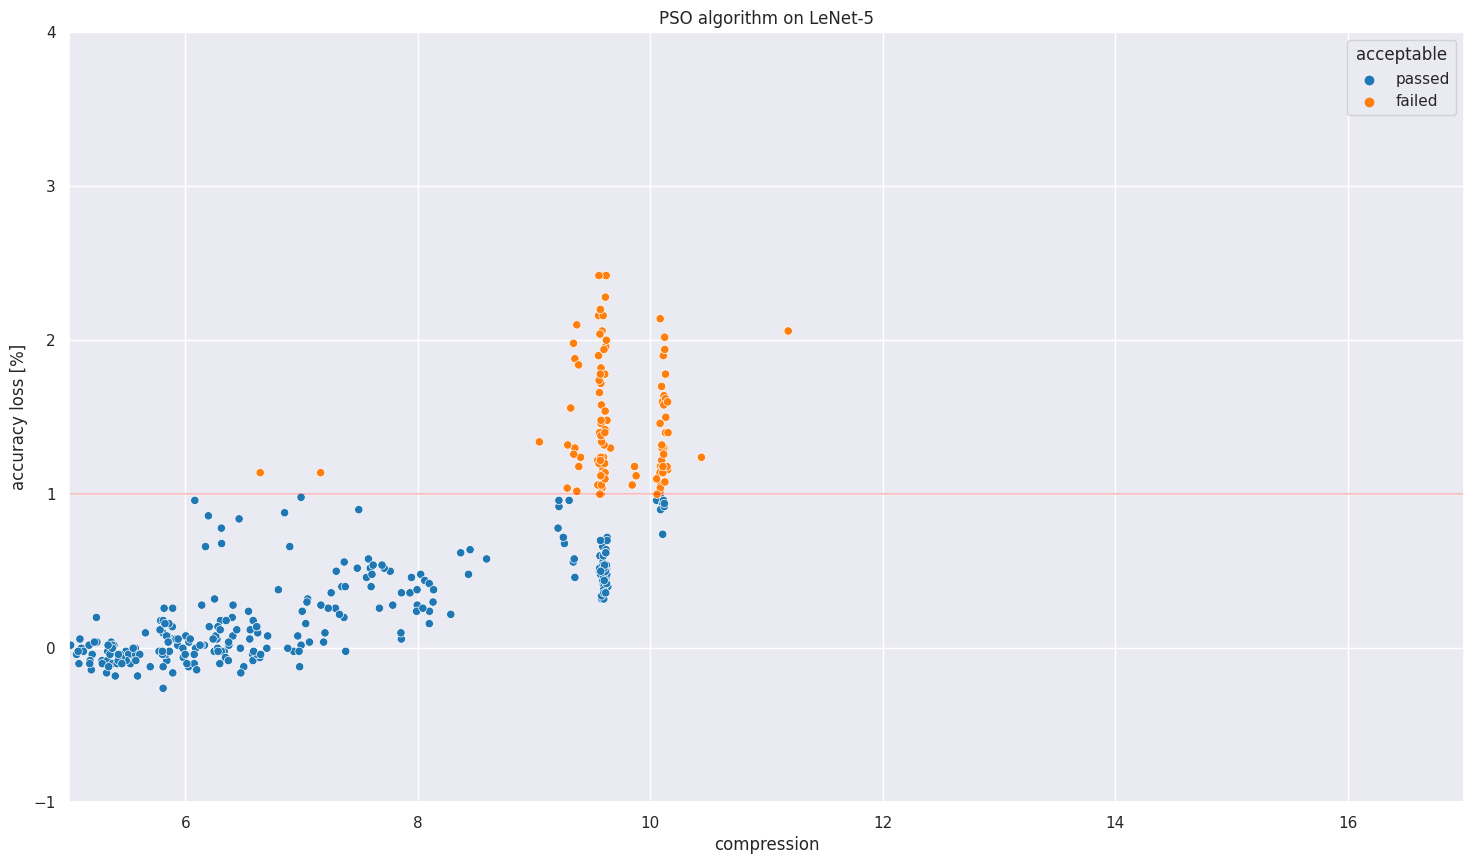

In [10]:
plot_alcr(pso_data)
plt.title('PSO algorithm on LeNet-5')